### normal vae

In [1]:
def extract_latent_space(data, model):
    model.eval()
    bio_z, mu1, logvar1, batch_z, batch_mu, batch_logvar, bio_batch_pred, batch_batch_pred, _mean, _disp, _pi, size_factor, size_mu, size_logvar = model(data)
    z1 = bio_z
    z2 = batch_z
    return z1.detach().cpu().numpy(), z2.detach().cpu().numpy(), _mean.detach().cpu().numpy(), _disp.detach().cpu().numpy(), _pi.detach().cpu().numpy()

In [2]:
import sys
import os
import importlib

scib_path = '/home/haiping_liu/code/My_model/Batch_VAE/Results/scib'
if scib_path not in sys.path:
    sys.path.append(scib_path)

import scib
importlib.reload(scib)

print(scib.__file__)

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/__init__.py


## Inference and visulization

In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from models.model import GeneVAE
from utils.dataset import GeneralDataset, GeneDataset
from utils.clustering import compute_weight, get_cluster_mean_indices, align_labels, compute_coassociation_matrix

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# load model
checkpoint_path = '/home/haiping_liu/code/My_model/Batch_VAE/saved/models/Pancreas/1231_162907/checkpoint-epoch105.pth'
checkpoint = torch.load(checkpoint_path)
config = checkpoint['config']._config if hasattr(checkpoint['config'], '_config') else checkpoint['config']
config_args = config['arch']['args']
model = GeneVAE(**config_args)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

data_dir ="/home/haiping_liu/code/My_model/Batch_VAE/Data/Gene_data/csv_format/pancreas_raw.csv"
train_dataset = GeneDataset(data_dir)
dataloader = DataLoader(train_dataset, shuffle=False, batch_size=128)

cell_types = []
latent = []
batch_ids = []
combine_z2 = []

model.eval()
model.to('cuda') 
with torch.no_grad():
    for batch in dataloader:
        features, batch_id, cell_type = batch
        features = features.to('cuda')
        cell_type = cell_type.to('cuda')
        batch_id = batch_id.to('cuda')
        z1, z2, _mean, _disp, _pi = extract_latent_space(features, model)

        latent.append(z1)
        combine_z2.append(z2)
        cell_types.append(cell_type.cpu().numpy())
        batch_ids.append(batch_id.cpu().numpy())

latent =  np.concatenate(latent, axis=0)
z2 = np.concatenate(combine_z2, axis=0)
cell_types = np.concatenate(cell_types, axis=0)
batch_ids = np.concatenate(batch_ids, axis=0)

# cell_type_names = dataset.cell_type
# cell_types_named = [cell_type_names[code] for code in cell_types]
data_df = pd.read_csv(data_dir)
cell_types = data_df['cell_type'].values 
batch_ids = data_df['batch'].values 

adata_z1 = sc.AnnData(latent)
adata_z1.obs['batch'] = batch_ids
adata_z1.obs['cell_type'] = cell_types

/tmp/ipykernel_837768/1802528983.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/tmp/ipykernel_837768/1802528983.py:16: Future

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


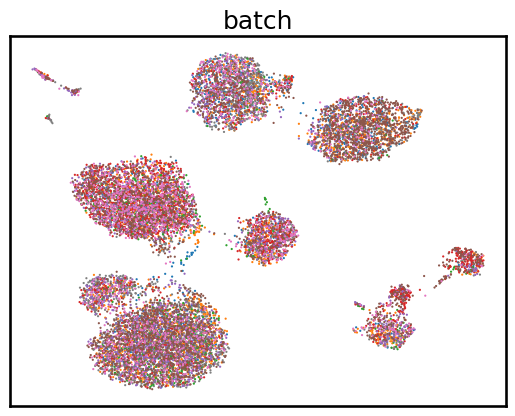

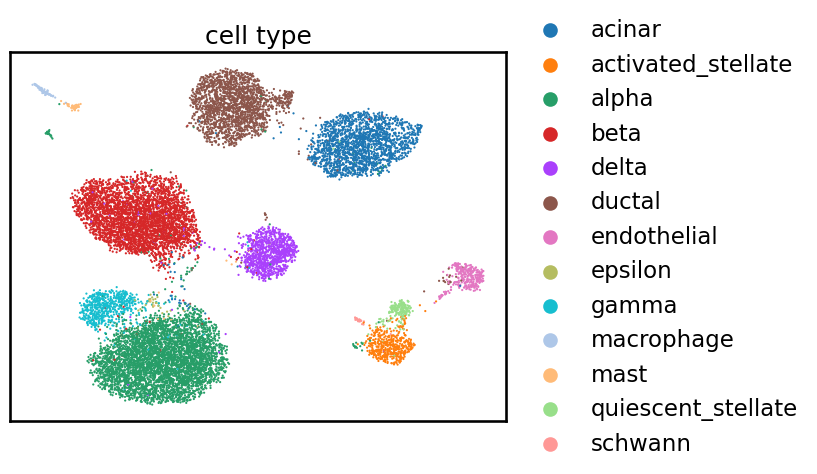

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pp.neighbors(adata_z1, use_rep='X')
sc.tl.umap(adata_z1)

ax1 = sc.pl.umap(
    adata_z1, color=['batch'], title="batch", legend_loc=None, size=10, show=False
)
ax1.set_xlabel("") 
ax1.set_ylabel("")  

ax2 = sc.pl.umap(
    adata_z1, color=['cell_type'], title="cell type", size=10,  show=False
)
ax2.set_xlabel("") 
ax2.set_ylabel("")  
plt.show()


In [6]:
import pandas as pd

df = pd.DataFrame(adata_z1.X, columns=[f'latent_{i}' for i in range(adata_z1.X.shape[1])])

df['BATCH'] = adata_z1.obs['batch'].values
df['celltype'] = adata_z1.obs['cell_type'].values

df.to_csv('pancreas_berd.csv', index=False)

<Figure size 800x640 with 0 Axes>

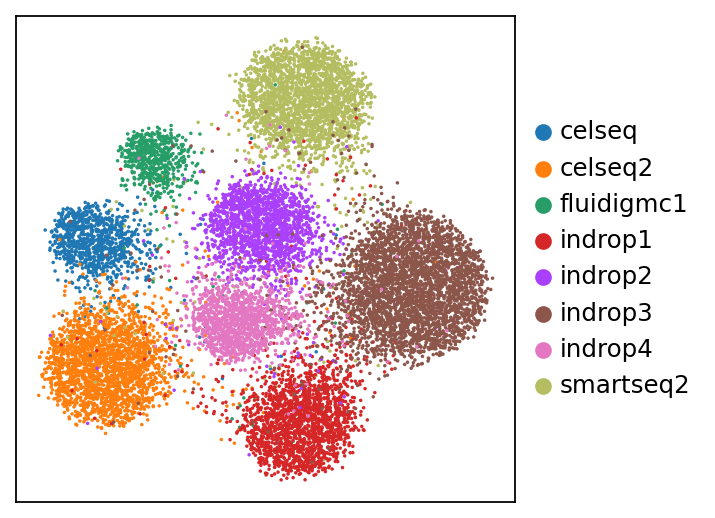

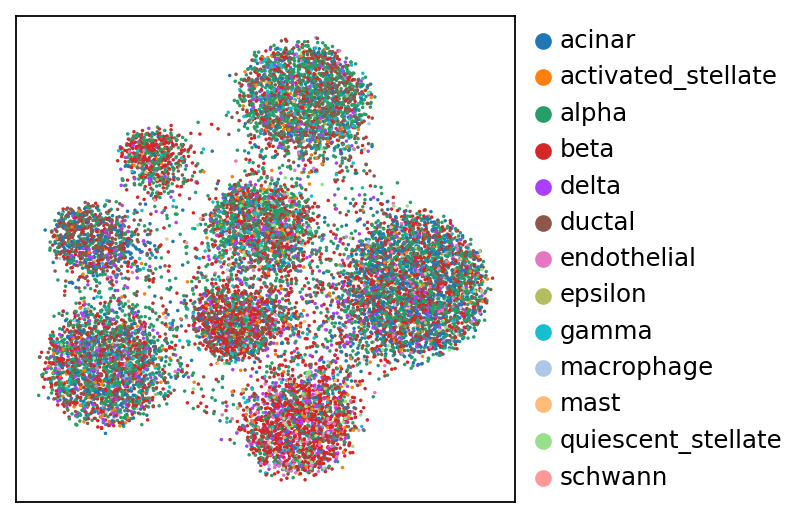

In [62]:
import scanpy as sc
import matplotlib.pyplot as plt

adata_z2 = sc.AnnData(z2)  
adata_z2.obs['batch'] = batch_ids
adata_z2.obs['cell_type'] = cell_types

# visulization
plt.figure(figsize=(10, 8))
sc.pp.neighbors(adata_z2, use_rep='X')  
sc.tl.umap(adata_z2) 

ax3 = sc.pl.umap(
    adata_z2, color=['batch'], title="", size=10, show=False
)
ax3.set_xlabel("") 
ax3.set_ylabel("")  

ax4 = sc.pl.umap(
    adata_z2, color=['cell_type'], title="", size=10,show=False
)
ax4.set_xlabel("") 
ax4.set_ylabel("")  
plt.show()

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


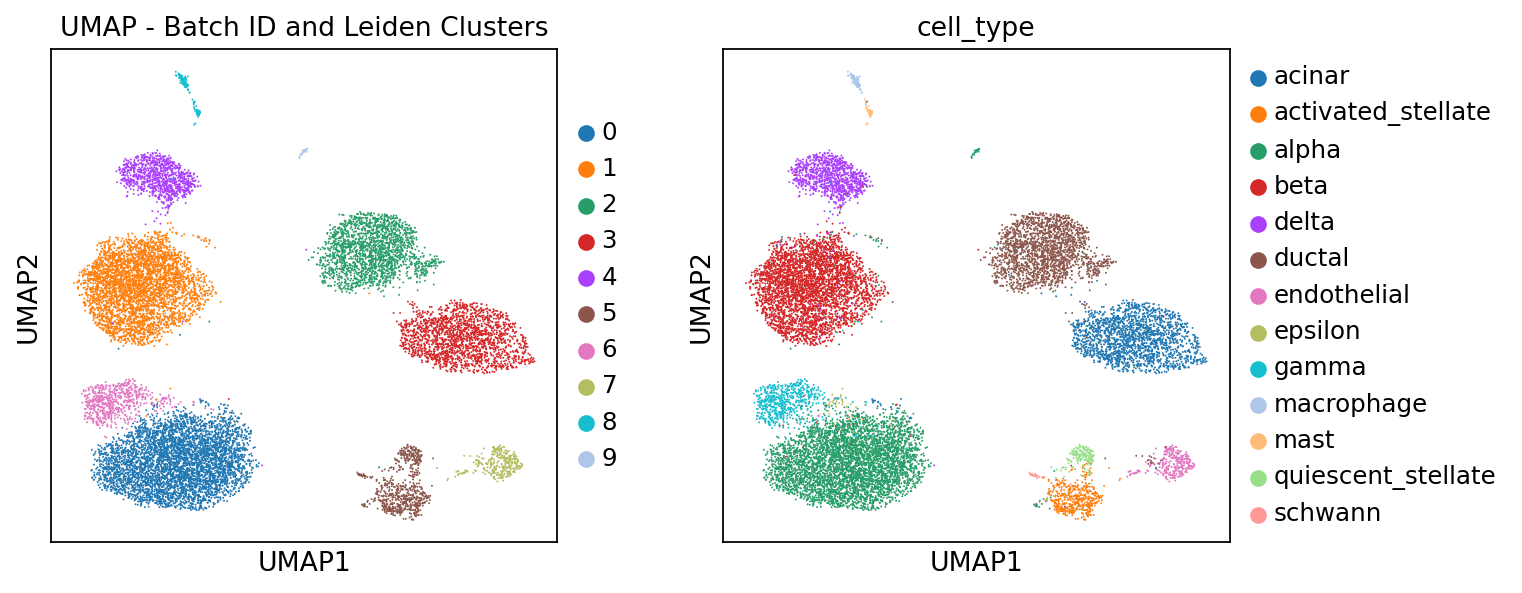

Adjusted Rand Index (ARI) score: 0.9442372110433109
Normalized Mutual Information (NMI) score: 0.9157274997739238


<Figure size 320x320 with 0 Axes>

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
)

sc.tl.leiden(adata_z1, resolution=0.4, key_added='leiden_clusters')
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_z1, color=['leiden_clusters', 'cell_type'], title="UMAP - Batch ID and Leiden Clusters", size=3)

cell_type_labels = adata_z1.obs['cell_type']
leiden_labels = adata_z1.obs['leiden_clusters']

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(cell_type_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(cell_type_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

plt.subplots_adjust(wspace=1)
plt.show()

<Figure size 800x640 with 0 Axes>

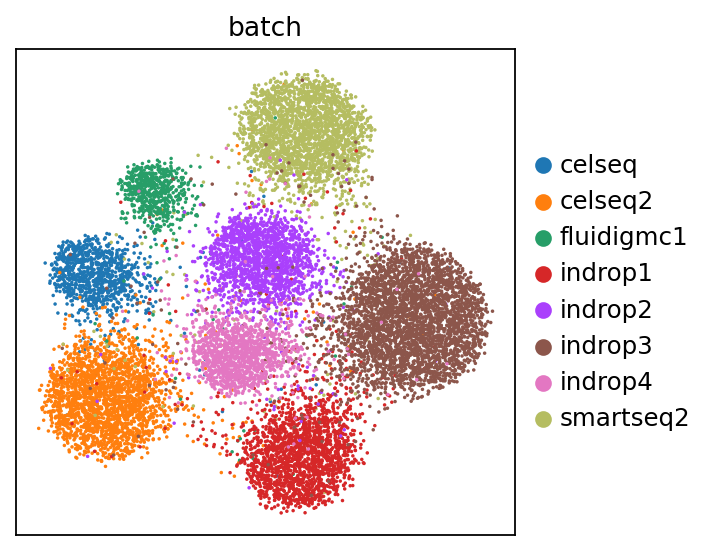

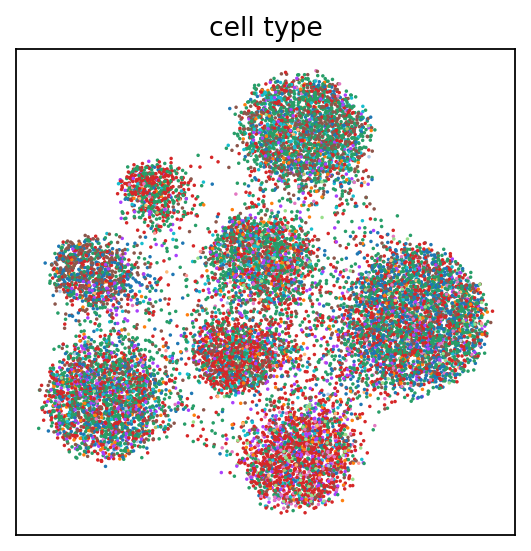

In [61]:
import scanpy as sc
import matplotlib.pyplot as plt

adata_z2 = sc.AnnData(z2)  
adata_z2.obs['batch'] = batch_ids
adata_z2.obs['cell_type'] = cell_types

# visulization
plt.figure(figsize=(10, 8))
sc.pp.neighbors(adata_z2, use_rep='X')  
sc.tl.umap(adata_z2) 

ax3 = sc.pl.umap(
    adata_z2, color=['batch'], title="batch", size=10, show=False
)
ax3.set_xlabel("") 
ax3.set_ylabel("")  

ax4 = sc.pl.umap(
    adata_z2, color=['cell_type'], legend_loc=None, title="cell type",size=10,show=False
)
ax4.set_xlabel("") 
ax4.set_ylabel("")  
plt.show()

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


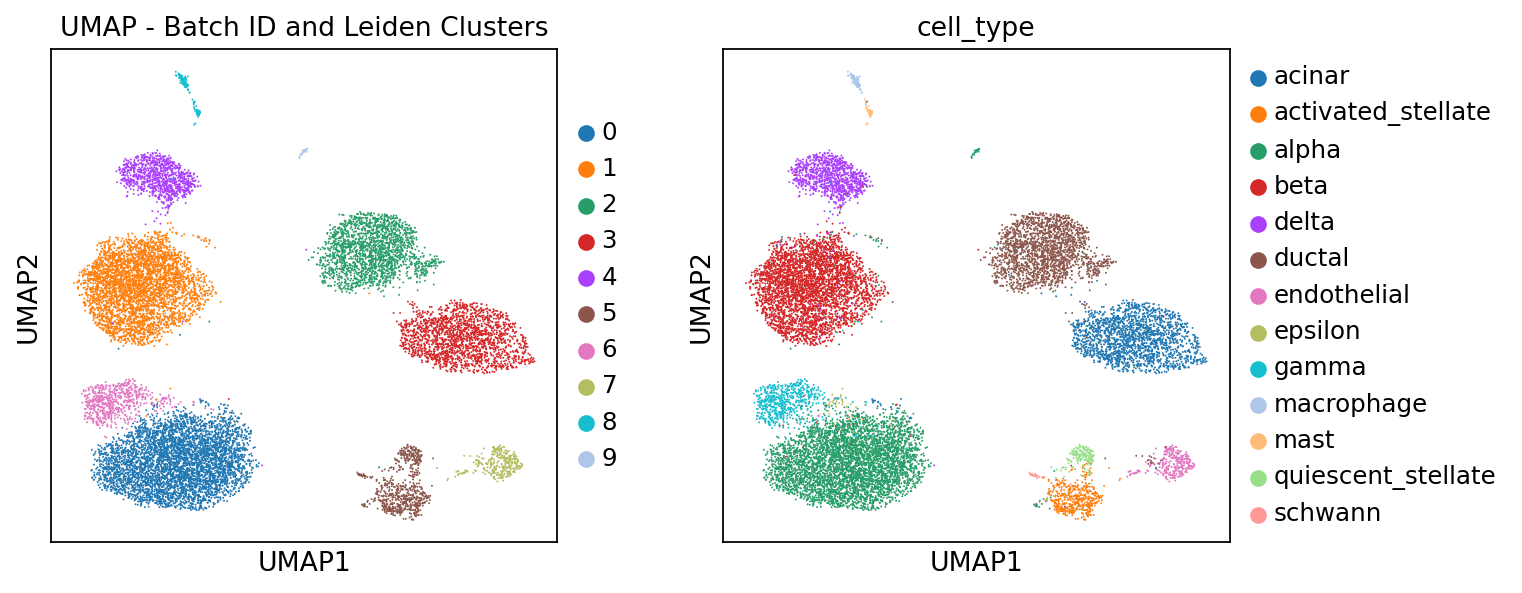

Adjusted Rand Index (ARI) score: 0.9442372110433109
Normalized Mutual Information (NMI) score: 0.9157274997739238


<Figure size 320x320 with 0 Axes>

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
)

sc.tl.leiden(adata_z1, resolution=0.4, key_added='leiden_clusters')
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_z1, color=['leiden_clusters', 'cell_type'], title="UMAP - Batch ID and Leiden Clusters", size=3)

cell_type_labels = adata_z1.obs['cell_type']
leiden_labels = adata_z1.obs['leiden_clusters']

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(cell_type_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(cell_type_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

plt.subplots_adjust(wspace=1)
plt.show()

# Evaluation

### 1. Batch effect

In [50]:
import scib
scib.metrics.ilisi_graph(adata_z1, batch_key='batch', type_="full")

In [52]:
scib.me.graph_connectivity(adata_z1, label_key="cell_type")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

0.9888492835154956

In [ ]:
scib.me.silhouette_batch(adata_z1, batch_key="batch", label_key="cell_type", embed='X_umap')

In [ ]:
# kbet
scib.me.kBET(adata_z1, batch_key="batch", label_key="cell_type", type_="embed", embed="X_pca")

In [41]:
data_dir ="/home/haiping_liu/code/My_model/Batch_VAE/Results/Gene_data/csv_format/pancreas_raw.csv"
table = pd.read_csv(data_dir)

data = table.iloc[:, 0:2000].values 

cell_type = table['cell_type'].values
batch_id = table['batch'].values

# build adata
adata = sc.AnnData(data)  
adata.obs['batch'] = batch_id 
adata.obs['cell_type'] = cell_type
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

scib.me.pcr_comparison(adata, adata_z1, covariate="batch")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


0.8777893636145108

### 2. Biological information

In [ ]:
sc.pp.neighbors(adata_z1)
scib.me.cluster_optimal_resolution(adata_z1, cluster_key="cluster", label_key="cell type")
scib.me.ari(adata_z1, cluster_key="cluster", label_key="cell type")

In [ ]:
scib.me.nmi(adata_z1, cluster_key="cluster", label_key="cell type")

In [40]:
sc.pp.pca(adata_z1)
scib.me.silhouette(adata_z1, label_key="cell_type", embed="X_pca")

0.625077947974205

In [ ]:
scib.me.clisi_graph(adata_z1, label_key="cell_type", type_="embed", use_rep="X_pca")

/root/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


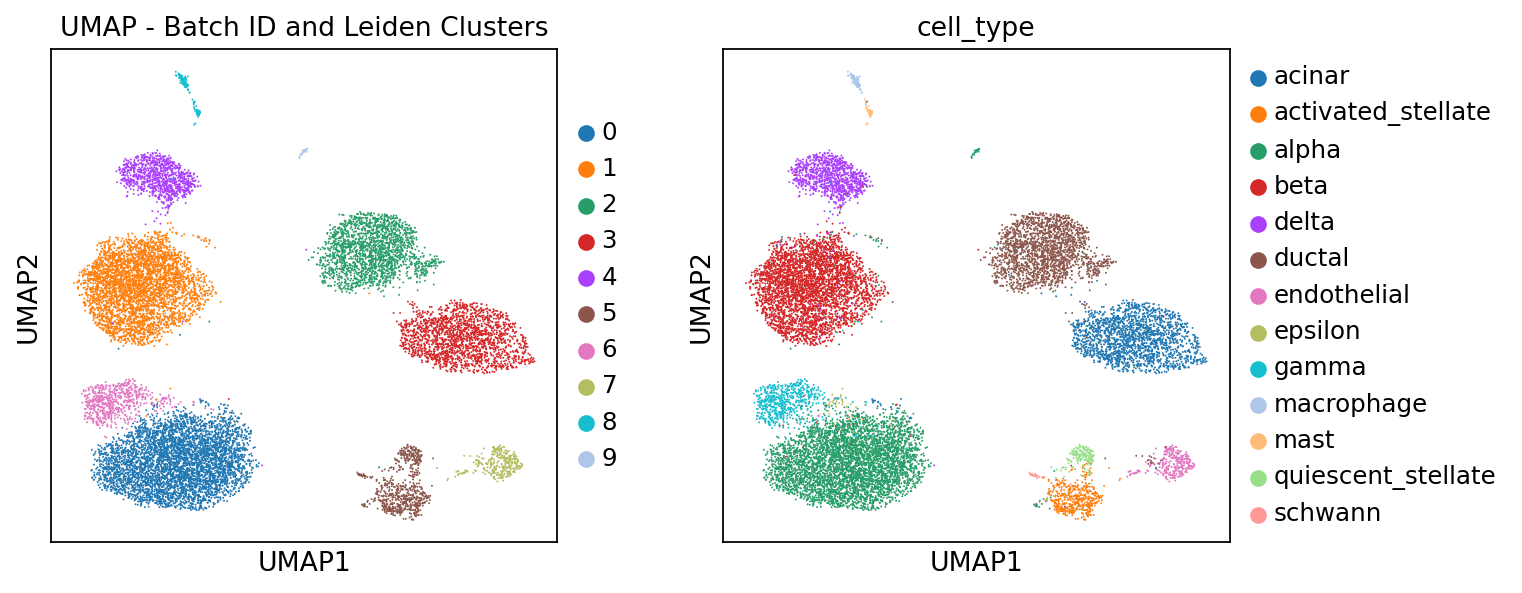

Adjusted Rand Index (ARI) score: 0.9442372110433109
Normalized Mutual Information (NMI) score: 0.9157274997739238


<Figure size 320x320 with 0 Axes>

In [47]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
)

sc.tl.leiden(adata_z1, resolution=0.4, key_added='leiden_clusters')
sc.settings.set_figure_params(fontsize=12)  
sc.pl.umap(adata_z1, color=['leiden_clusters', 'cell_type'], title="UMAP - Batch ID and Leiden Clusters", size=3)

cell_type_labels = adata_z1.obs['cell_type']
leiden_labels = adata_z1.obs['leiden_clusters']

# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(cell_type_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Normalized Mutual Information (NMI)
nmi_score = normalized_mutual_info_score(cell_type_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI) score: {nmi_score}")

plt.subplots_adjust(wspace=1)
plt.show()